<a href="https://colab.research.google.com/github/avner8943/bootcamp/blob/master/transfer_learnning_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np


class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        

        self.conv1 = nn.Conv2d(3, 6, 5)

        self.conv2 = nn.Conv2d(6, 16, 5)

        # randomly select number of feagtures
        fet1 = np.random.randint(100, 400)

        fet2 = np.random.randint(100, 400)

        
        self.fc1 = nn.Linear(in_features= 16 * 5 * 5, out_features=fet1)  # 6*6 from image dimension
        
        self.fc2 = nn.Linear(in_features=fet1, out_features=fet2)

        self.fc3 = nn.Linear(in_features=fet2, out_features=n_classes)
    
    def forward(self, x):

        x = F.max_pool2d(torch.relu(self.conv1(x)), kernel_size=2)
        x = F.max_pool2d(torch.relu(self.conv2(x)), kernel_size=2)
  
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)

        return x

In [3]:
class im_resize(object):

  def __init__(self, o_shape = (3,32,32)):
    self.o_shape = o_shape



  def __call__(self, im):

    c, h, w = self.o_shape
    new_im = transforms.Resize(im, (c,h, w))

    return new_im

In [4]:
def data_loader_CIFAR10():

  transform = transforms.Compose(
      [transforms.ToTensor(),
       transforms.RandomHorizontalFlip(p=0.5),
       transforms.Resize((32,32)),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=4,
                                            shuffle=True, num_workers=2)

  test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,
                                          shuffle=False, num_workers=2)
  classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  return train_set, train_loader, test_set, test_loader, classes

In [5]:
import torch.optim as optim

train_set, train_loader, test_set, test_loader, classes = data_loader_CIFAR10()
print(train_loader)

net = LeNet5(len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
# train model
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print(outputs.shape, inputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,  2000] loss: 2.187
[1,  4000] loss: 1.839
[1,  6000] loss: 1.666
[1,  8000] loss: 1.547
[1, 10000] loss: 1.474
[1, 12000] loss: 1.419
[2,  2000] loss: 1.369
[2,  4000] loss: 1.298
[2,  6000] loss: 1.299
[2,  8000] loss: 1.272
[2, 10000] loss: 1.243
[2, 12000] loss: 1.220


In [7]:
# evaluate model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


same results as for last assignment

### Q2.a implent tutorial transfer learnning from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [8]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

In [9]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['.ipynb_checkpoints', 'ants', 'bees']


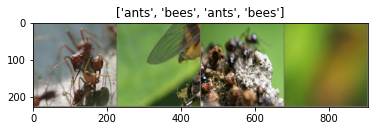

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #inputs = inputs.to(device)
                #labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #print(preds, labels)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())



    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [18]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            #inputs = inputs.to(device)
            #labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [19]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
print(num_ftrs)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))


#model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

512


In [20]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6557 Acc: 0.6352
val Loss: 0.1981 Acc: 0.9085
Epoch 1/24
----------
train Loss: 0.7348 Acc: 0.7295
val Loss: 0.2984 Acc: 0.8562
Epoch 2/24
----------
train Loss: 0.6202 Acc: 0.7541
val Loss: 0.2591 Acc: 0.8954
Epoch 3/24
----------
train Loss: 0.4865 Acc: 0.8115
val Loss: 0.3802 Acc: 0.8497
Epoch 4/24
----------
train Loss: 0.5930 Acc: 0.7459
val Loss: 0.3240 Acc: 0.8954
Epoch 5/24
----------
train Loss: 0.4384 Acc: 0.8689
val Loss: 0.4174 Acc: 0.8758
Epoch 6/24
----------
train Loss: 0.4469 Acc: 0.8320
val Loss: 0.2734 Acc: 0.8693
Epoch 7/24
----------
train Loss: 0.3672 Acc: 0.8320
val Loss: 0.2620 Acc: 0.8954
Epoch 8/24
----------
train Loss: 0.3642 Acc: 0.8484
val Loss: 0.2455 Acc: 0.8954
Epoch 9/24
----------
train Loss: 0.3090 Acc: 0.8730
val Loss: 0.2280 Acc: 0.8889
Epoch 10/24
----------
train Loss: 0.3013 Acc: 0.8648
val Loss: 0.2719 Acc: 0.9085
Epoch 11/24
----------
train Loss: 0.3298 Acc: 0.8238
val Loss: 0.2576 Acc: 0.9085
Epoch 12/24
--

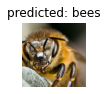

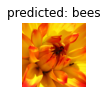

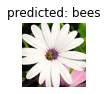

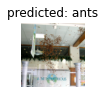

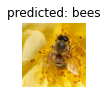

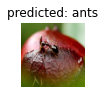

In [21]:
visualize_model(model_ft)

### Q2.b Transfer learnning CIFAR10

In [22]:
transform = transforms.Compose(
    [transforms.ToTensor(),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.Resize((32,32)),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

class CifarPartialDataSet(torchvision.datasets.CIFAR10):

  def __init__(self, ind_range, train=True, transform=None, target_transform=None):

    self.train = train
    assert isinstance (ind_range, tuple)
    from_ind, to_ind = ind_range
    assert 0 <= from_ind < to_ind < 10
    self.transform = transform
    self.target_transform = target_transform

    if train:
      cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

      targets = np.array(cifar10_train.targets, dtype=np.int64)
      indices = (from_ind <= targets) & (targets <= to_ind)
      self.data = cifar10_train.data[indices]
      self.targets = list(targets[indices]-from_ind)
    else:
      cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
      targets = np.array(cifar10_test.targets, dtype=np.int64)
      indices = (from_ind <= targets) & (targets <= to_ind)
      self.data = cifar10_test.data[indices]
      self.targets = list(targets[indices]-from_ind)

cifar07_train = CifarPartialDataSet((0,7), True, transform=transform)

cifar_train = CifarPartialDataSet((8,9), True, transform=transform)




cifar07_train_loader = torch.utils.data.DataLoader(cifar07_train, batch_size=4, shuffle=True, num_workers=0)

cifar07_test = CifarPartialDataSet((0,7), False, transform=transform)

cifar07_test_loader = torch.utils.data.DataLoader(cifar07_test, batch_size=4, shuffle=True, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np


class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        

        self.conv1 = nn.Conv2d(3, 6, 5)

        self.conv2 = nn.Conv2d(6, 16, 5)



        
        self.fc1 = nn.Linear(in_features= 16 * 5 * 5, out_features=256)  # 6*6 from image dimension
        
        self.fc2 = nn.Linear(in_features=256, out_features=128)

        self.fc3 = nn.Linear(in_features=128, out_features=10)
    
    def forward(self, x):

        x = F.max_pool2d(torch.relu(self.conv1(x)), kernel_size=2)
        x = F.max_pool2d(torch.relu(self.conv2(x)), kernel_size=2)
  
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)

        return x

In [24]:
import torch.optim as optim


net = LeNet5(10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [25]:
# train model
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(cifar07_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        #print(outputs.shape)#, inputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,  2000] loss: 1.995
[1,  4000] loss: 1.655
[1,  6000] loss: 1.491
[1,  8000] loss: 1.398
[1, 10000] loss: 1.337
[2,  2000] loss: 1.295
[2,  4000] loss: 1.279
[2,  6000] loss: 1.235
[2,  8000] loss: 1.185
[2, 10000] loss: 1.178


In [26]:
# evaluate model
correct = 0
total = 0
with torch.no_grad():
    for data in cifar07_test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


In [30]:
f_name = "net_weights.pt"

torch.save(net.state_dict(), f_name)

In [31]:
for param in net.parameters():
    param.requires_grad = False

In [36]:
state = torch.load('/content/net_weights.pt')

new_net = LeNet5(len(classes))


new_net.load_state_dict(state)

for param in new_net.parameters():
    param.requires_grad = False

new_net =  nn.Sequential(
    new_net,
    nn.Linear(10, 256),
    nn.Linear(256,10)
)
print(new_net)

Sequential(
  (0): LeNet5(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=400, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=10, bias=True)
  )
  (1): Linear(in_features=10, out_features=256, bias=True)
  (2): Linear(in_features=256, out_features=10, bias=True)
)


In [37]:
cifar10_train = CifarPartialDataSet((8,9), True, transform=transform)

cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=4, shuffle=True, num_workers=0)

cifar10_test = CifarPartialDataSet((8,9), False, transform=transform)

cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=4, shuffle=True, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [38]:
optimizer = optim.SGD(new_net.parameters(), lr=0.01, momentum=0.9)

# train model
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(cifar10_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = new_net(inputs)
        #print(outputs.shape)#, inputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,  2000] loss: 0.696
[2,  2000] loss: 0.510
[3,  2000] loss: 0.512
[4,  2000] loss: 0.519
[5,  2000] loss: 0.493
[6,  2000] loss: 0.495
[7,  2000] loss: 0.494
[8,  2000] loss: 0.495
[9,  2000] loss: 0.481
[10,  2000] loss: 0.501


In [39]:
# evaluate model
correct = 0
total = 0
with torch.no_grad():
    for data in cifar10_test_loader:
        images, labels = data
        outputs = new_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 78 %
